# Laptop Prices Prediction
This analysis and model will be used to find correlation between specs and laptop price aswell as being used to predict laptop prices in the future.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

In [2]:
laptops = pd.read_csv('/kaggle/input/laptop-price/laptop_price.csv',encoding='latin-1')
laptops = laptops.set_index('laptop_ID')
laptops.head()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
laptop_ID,,,,,,,,,,,,
1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


In [3]:
laptops.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1303 entries, 1 to 1320
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           1303 non-null   object 
 1   Product           1303 non-null   object 
 2   TypeName          1303 non-null   object 
 3   Inches            1303 non-null   float64
 4   ScreenResolution  1303 non-null   object 
 5   Cpu               1303 non-null   object 
 6   Ram               1303 non-null   object 
 7   Memory            1303 non-null   object 
 8   Gpu               1303 non-null   object 
 9   OpSys             1303 non-null   object 
 10  Weight            1303 non-null   object 
 11  Price_euros       1303 non-null   float64
dtypes: float64(2), object(10)
memory usage: 132.3+ KB


In [4]:
laptops.describe()

,Inches,Price_euros
count,1303.000000,1303.000000
mean,15.017191,1123.686992
std,1.426304,699.009043
min,10.100000,174.000000
25%,14.000000,599.000000
50%,15.600000,977.000000
75%,15.600000,1487.880000
max,18.400000,6099.000000


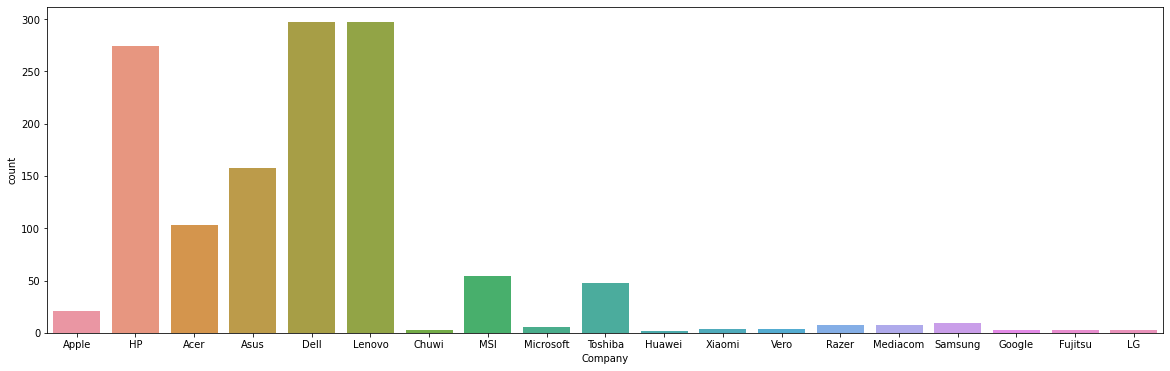

In [5]:
laptops['Company'].value_counts()
fig_dims = (20, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sb.countplot(x="Company", data=laptops, ax=ax)

In [6]:
laptops["Ram"] = laptops["Ram"].str.replace('GB', '')
laptops["Weight"] = laptops["Weight"].str.replace('kg', '')
laptops['Memory'] = laptops['Memory'].astype(str).replace('\.0', '', regex=True)
laptops["Memory"] = laptops["Memory"].str.replace('GB', '')
laptops["Memory"] = laptops["Memory"].str.replace('TB', '000')
new2 = laptops["Memory"].str.split("+", n = 1, expand = True)
laptops["first"]= new2[0]
laptops["first"]=laptops["first"].str.strip()
laptops["second"]= new2[1]
laptops["Layer1HDD"] = laptops["first"].apply(lambda x: 1 if "HDD" in x else 0)
laptops["Layer1SSD"] = laptops["first"].apply(lambda x: 1 if "SSD" in x else 0)
laptops["Layer1Hybrid"] = laptops["first"].apply(lambda x: 1 if "Hybrid" in x else 0)
laptops["Layer1Flash_Storage"] = laptops["first"].apply(lambda x: 1 if "Flash Storage" in x else 0)
laptops['first'] = laptops['first'].str.replace(r'\D', '')
laptops["second"].fillna("0", inplace = True)
laptops["Layer2HDD"] = laptops["second"].apply(lambda x: 1 if "HDD" in x else 0)
laptops["Layer2SSD"] = laptops["second"].apply(lambda x: 1 if "SSD" in x else 0)
laptops["Layer2Hybrid"] = laptops["second"].apply(lambda x: 1 if "Hybrid" in x else 0)
laptops["Layer2Flash_Storage"] = laptops["second"].apply(lambda x: 1 if "Flash Storage" in x else 0)
laptops['second'] = laptops['second'].str.replace(r'\D', '')
laptops["first"] = laptops["first"].astype(int)
laptops["second"] = laptops["second"].astype(int)
laptops["Total_Memory"]=(laptops["first"]*(laptops["Layer1HDD"]+laptops["Layer1SSD"]+laptops["Layer1Hybrid"]+laptops["Layer1Flash_Storage"])+laptops["second"]*(laptops["Layer2HDD"]+laptops["Layer2SSD"]+laptops["Layer2Hybrid"]+laptops["Layer2Flash_Storage"]))
laptops["Memory"]=laptops["Total_Memory"]
laptops["HDD"]=(laptops["first"]*laptops["Layer1HDD"]+laptops["second"]*laptops["Layer2HDD"])
laptops["SSD"]=(laptops["first"]*laptops["Layer1SSD"]+laptops["second"]*laptops["Layer2SSD"])
laptops["Hybrid"]=(laptops["first"]*laptops["Layer1Hybrid"]+laptops["second"]*laptops["Layer2Hybrid"])
laptops["Flash_Storage"]=(laptops["first"]*laptops["Layer1Flash_Storage"]+laptops["second"]*laptops["Layer2Flash_Storage"])
new = laptops["ScreenResolution"].str.split("x", n = 1, expand = True) 
laptops["X_res"]= new[0]
laptops["Y_res"]= new[1]
laptops["Y_res"]= pd.to_numeric(laptops["Y_res"])
laptops["Y_res"]= laptops["Y_res"].astype(float)
laptops["X_res"]=(laptops['X_res'].str.replace(',','').str.findall(r'(\d+\.?\d+)').apply(lambda x: pd.Series(x).astype(int)).mean(1))
laptops["X_res"]=pd.to_numeric(laptops["X_res"])
laptops["PPI"]=(((laptops["X_res"]**2+laptops["Y_res"]**2)**(1/2))/laptops["Inches"]).astype(float)
laptops["ScreenResolution"]=(laptops["X_res"]*laptops["Y_res"]).astype(float)
laptops["Ram"] = laptops["Ram"].astype(int)
laptops["Weight"] = laptops["Weight"].astype(float)
laptops=laptops.drop(['first','second','Layer1HDD','Layer1SSD','Layer1Hybrid','Layer1Flash_Storage','Layer2HDD','Layer2SSD','Layer2Hybrid','Layer2Flash_Storage','Total_Memory'],axis=1)

In [7]:
laptops.head(5)

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros,HDD,SSD,Hybrid,Flash_Storage,X_res,Y_res,PPI
laptop_ID,,,,,,,,,,,,,,,,,,,
1,Apple,MacBook Pro,Ultrabook,13.3,4096000.0,Intel Core i5 2.3GHz,8,128,Intel Iris Plus Graphics 640,macOS,1.37,1339.69,0,128,0,0,2560.0,1600.0,226.983005
2,Apple,Macbook Air,Ultrabook,13.3,1296000.0,Intel Core i5 1.8GHz,8,128,Intel HD Graphics 6000,macOS,1.34,898.94,0,0,0,128,1440.0,900.0,127.677940
3,HP,250 G6,Notebook,15.6,2073600.0,Intel Core i5 7200U 2.5GHz,8,256,Intel HD Graphics 620,No OS,1.86,575.00,0,256,0,0,1920.0,1080.0,141.211998
4,Apple,MacBook Pro,Ultrabook,15.4,5184000.0,Intel Core i7 2.7GHz,16,512,AMD Radeon Pro 455,macOS,1.83,2537.45,0,512,0,0,2880.0,1800.0,220.534624
5,Apple,MacBook Pro,Ultrabook,13.3,4096000.0,Intel Core i5 3.1GHz,8,256,Intel Iris Plus Graphics 650,macOS,1.37,1803.60,0,256,0,0,2560.0,1600.0,226.983005


In [8]:
X = laptops.drop(['Price_euros'],axis=1)
Y = laptops['Price_euros'].values
X = X.select_dtypes(exclude=['object'])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [10]:
SGDreg = SGDRegressor()
SGDreg.fit(X_train, y_train)

SGDRegressor()

In [11]:
Kreg = KNeighborsRegressor()
Kreg.fit(X_train, y_train)

KNeighborsRegressor()

In [12]:
pred = Kreg.predict(X_train)
k_mse = mean_squared_error(y_train, pred)
k_rmse = np.sqrt(k_mse)
k_rmse

325.20943566703335

In [13]:
param_grid = {'n_neighbors': np.arange(1, 12, 2),
              'weights': ['uniform', 'distance']}
grid_search = GridSearchCV(Kreg, param_grid)
grid_search.fit(X_train, y_train)
print("Best score: " + str(grid_search.best_score_))

Best score: 0.648011578738852


In [14]:
final_model = grid_search.best_estimator_
final_pred = final_model.predict(X_test)
final_pred = final_pred.tolist()
for pred in range(0, len(final_pred)):
    print("Predicition: " + str(round(final_pred[pred], 2)) + " Actual: " + str(y_test[pred]))

Predicition: 1382.67 Actual: 1672.0
Predicition: 1232.0 Actual: 1149.0
Predicition: 614.0 Actual: 499.0
Predicition: 1065.67 Actual: 899.0
Predicition: 1614.33 Actual: 1244.0
Predicition: 1795.33 Actual: 1398.99
Predicition: 875.0 Actual: 719.0
Predicition: 469.0 Actual: 459.0
Predicition: 1126.5 Actual: 1191.0
Predicition: 586.67 Actual: 349.0
Predicition: 2289.81 Actual: 1899.0
Predicition: 928.54 Actual: 726.0
Predicition: 1449.0 Actual: 1813.0
Predicition: 483.67 Actual: 805.99
Predicition: 2190.0 Actual: 1949.0
Predicition: 1126.8 Actual: 899.0
Predicition: 1298.0 Actual: 1145.0
Predicition: 928.54 Actual: 961.0
Predicition: 590.67 Actual: 713.07
Predicition: 1641.0 Actual: 1649.0
Predicition: 2605.6 Actual: 2349.0
Predicition: 395.66 Actual: 720.32
Predicition: 919.0 Actual: 798.01
Predicition: 481.42 Actual: 265.0
Predicition: 953.0 Actual: 1149.0
Predicition: 1499.0 Actual: 999.0
Predicition: 682.97 Actual: 959.0
Predicition: 750.33 Actual: 825.0
Predicition: 1474.0 Actual: 227